In [2]:
import numpy as np
from cohlib.utils import pickle_open
from cohlib.alg.laplace_sgc import SpikeTrial, TrialData

In [3]:
mu = -3.5
L = 25 
C = 30
sample_length = 1000
seed = 8

save_path = f'saved/synthetic_data/simple_synthetic_{L}_{sample_length}_{C}_{mu}_{seed}'

data_load = pickle_open(save_path)

data_load['meta'].keys()
Gamma = data_load['latent']['Gamma']
Wv = data_load['meta']['Wv']
freqs = data_load['meta']['freqs']
vs = data_load['latent']['vs']
zs = data_load['latent']['zs']

spikes = data_load['observed']['spikes']
freqs = data_load['meta']['freqs']

In [4]:
from cohlib.alg.em_sgc import transform_cov_c2r, est_cov_r2c
transform_cov_r2c = est_cov_r2c

In [6]:
# sample_length = data_load['meta']['sample_length']
# fs = data_load['meta']['fs']
# frange = [0, int(fs/2)]
# res = fs/sample_length


q = 1
num_J_vars = Wv.shape[1]
K = 2
Gamma_inv_init = np.eye(K*num_J_vars)*q
for k in range(K):
    d = k*num_J_vars
    Gamma_inv_init[d,d] = 0

spikes_short = spikes[:10,:,:,:]
spikes_use = spikes_short
spikes_grouped = [spikes_use[:,:,k,:] for k in range(K)]

In [10]:
Wvmod = Wv.copy()
Wvmod[:,0] = 0

In [12]:
from cohlib.alg.em_sgc import fit_sgc_model
# Gamma_inv_init = track[0]['inv']
inits = {'Gamma_inv_init': Gamma_inv_init}
num_em = 1

mu = -3.5
Gamma_est, prev_inv, track = fit_sgc_model(spikes_grouped, Wvmod, inits, mu, num_em_iters=num_em, 
            max_approx_iters=15, track=True)



EM iter: 0
Laplace Approx trial 0
Laplace Approx trial 1
Laplace Approx trial 2
Laplace Approx trial 3
Laplace Approx trial 4
Laplace Approx trial 5
Laplace Approx trial 6
Laplace Approx trial 7
Laplace Approx trial 8
Laplace Approx trial 9
M-Step for EM iter 0


In [13]:
track[0]['inv']

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -4.78826522e+00, -3.97802022e-02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -3.97802022e-02, -1.76655195e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.89842518e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  6.18778768e+01, -3.81911332e-13],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00, -3.81911332e-13,  1.00000000e+00]])

In [10]:
# np.linalg.inv(track[0]['DC'])

In [15]:
Gamma_update_real = Gamma_est
from cohlib.alg.em_sgc import rearrange_mat
J = int((num_J_vars-1)/2)
# Gamma_est_complex = np.stack([transform_cov_r2c(np.linalg.inv(4*rearrange_mat(Gamma_update_real[j,:,:], K))) for j in range(J)])
# Gamma_est_complex.shape

In [16]:
# Gamma_est_complex = np.stack([transform_cov_r2c(np.linalg.inv(4*rearrange_mat(Gamma_update_real[j,:,:], K))) for j in range(J)])
track_complex = []
for i in range(num_em):
   complex_i = np.stack([transform_cov_r2c(rearrange_mat(track[i]['real'][j,:,:], K)) for j in range(J)]) 
   track_complex.append(complex_i)

In [17]:
j_ind = 9
track_complex[0].shape

(500, 2, 2)

In [18]:
j_ind = 9
print("True Gamma_j:")
print(Gamma[j_ind,:,:])
print()
for i in range(num_em):

    print(f"Trial {i}")
    # print(track[i]["complex"][j_ind,:,:]*(J*2/(np.pi)))
    # print(track[i]["complex"][j_ind,:,:])
    print(track_complex[i][j_ind,:,:])
    print()

True Gamma_j:
[[2500.           +0.j         1290.02543329+1904.16238316j]
 [1290.02543329-1904.16238316j 2500.           +0.j        ]]

Trial 0
[[13.25974372+0.j         8.33433661-9.8290176j]
 [ 8.33433661+9.8290176j 16.42090427+0.j       ]]

Trial 1
[[6424324.13256184      +0.j         3689753.37548565-4054468.30164327j]
 [3689753.37548565+4054468.30164327j 8105880.33793943      +0.j        ]]

Trial 2
[[388.2172271   +0.j         221.48101123-260.09087858j]
 [221.48101123+260.09087858j 463.85203778  +0.j        ]]



In [19]:
np.abs(track_complex[1])[9,:,:]

array([[6424324.13256184, 5482061.03403983],
       [5482061.03403983, 8105880.33793943]])

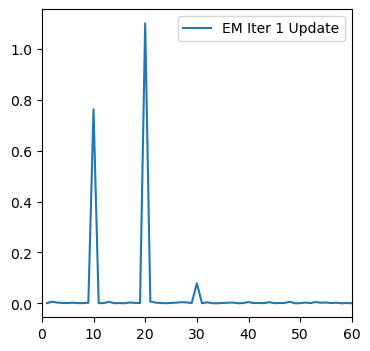

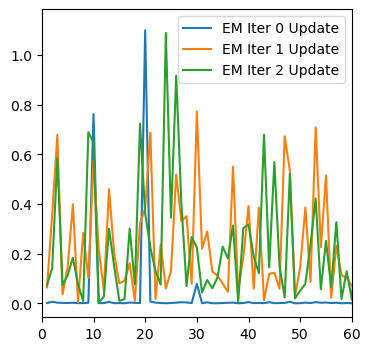

In [20]:
import matplotlib.pyplot as plt
from cohlib.estimation import estimate_coherence, thr_coherence

fig, ax = plt.subplots(figsize=(4,4))
# est = track[0]["complex"]
est = track_complex[0]
coh = thr_coherence(est)
ax.plot(freqs, coh, label="EM Iter 1 Update")
ax.set_xlim([0,60])
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(4,4))
for n in range(num_em):
    # est = track[n]["complex"]
    est = track_complex[n]
    coh = thr_coherence(est)
    ax.plot(freqs, coh, label=f"EM Iter {n} Update")
    plt.legend()
    ax.set_xlim([0,60])

In [19]:
# J = 500
# from cohlib.alg.em_sgc import construct_Gamma_full_real, get_freq_mats_real, rearrange_mat, est_cov_r2c, reverse_rearrange_mat, transform_cov_c2r
# freq_mats_real = get_freq_mats_real(Gamma_inv_init,K,1000)
# r = freq_mats_real[0]
# c_init = est_cov_r2c(rearrange_mat(r, K))

# Gamma_init = np.zeros((J,K,K), dtype=complex)
# for j in range(J):
#     Gamma_init[j,:,:] = np.linalg.inv(c_init)


IndexError: boolean index did not match indexed array along dimension 0; dimension is 2002 but corresponding boolean dimension is 2000

NameError: name 'Gamma_init' is not defined

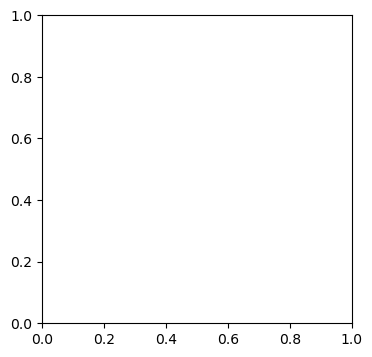

In [15]:
fig, ax = plt.subplots(figsize=(4,4))
coh = thr_coherence(Gamma_init)
true_coh = thr_coherence(Gamma)
ax.plot(freqs, coh, label="Init")
ax.plot(freqs, true_coh, label="True")
ax.set_xlim([0,60])
plt.legend()
plt.show()

In [ ]:
est_cov_r2c(rearrange_mat(inv_j_real, K))

array([[2.+0.j, 0.+0.j],
       [0.+0.j, 2.+0.j]])

In [ ]:
j_ind = 1
est = track[i]["complex"][j_ind,:,:]

inv_full = track[i]["inv"]

In [ ]:
inv_full_js = get_freq_mats_real(inv_full, K, 1000)

In [ ]:
print(est_cov_r2c(rearrange_mat(inv_full_js[j_ind], K)))
print(np.linalg.inv(est))

[[5.20302888-3.63189004e-17j 5.59962781-6.71587198e-01j]
 [5.59962781+6.71587198e-01j 7.57899601-1.20478076e-17j]]
[[5.20302888+3.63189004e-17j 5.59962781+6.71587198e-01j]
 [5.59962781-6.71587198e-01j 7.57899601+1.20478076e-17j]]


(0.0, 60.0)

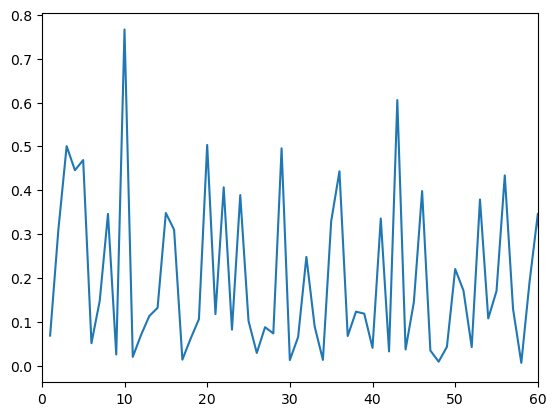

In [ ]:
plt.plot(freqs, temp)
plt.xlim([0,60])

In [ ]:
def transform_cov_c2r(complex_cov):
    dim = complex_cov.shape[0]
    A = np.real(complex_cov)
    B = np.imag(complex_cov)
    rcov = np.zeros((2*dim, 2*dim))
    
    rcov = np.block([[A, -B],
                     [B, A]])

    return rcov/2
def rearrange_mat(mat, K):
    temp = np.tile(np.array([1,0]), K)
    f1 = np.outer(temp, temp)
    f2 = np.roll(f1,1,axis=1)
    f3 = np.roll(f1,1,axis=0)
    f4 = np.roll(f1,1,axis=(0,1))

    A = mat[f1.astype(bool)].reshape(K,-1)
    B = mat[f2.astype(bool)].reshape(K,-1)
    C = mat[f3.astype(bool)].reshape(K,-1)
    D = mat[f4.astype(bool)].reshape(K,-1)
    
    new_mat = np.block([[A, B],
                       [C, D]])
    return new_mat

def reverse_rearrange_mat(mat, K):
    temp = np.tile(np.array([1,0]), K)
    f1 = np.outer(temp, temp)
    f2 = np.roll(f1,1,axis=1)
    f3 = np.roll(f1,1,axis=0)
    f4 = np.roll(f1,1,axis=(0,1))

    dimC = K

    A = mat[:dimC,:dimC]
    B = mat[:dimC,dimC:]
    C = mat[dimC:,:dimC]
    D = mat[dimC:,dimC:]

    new_mat = np.zeros_like(mat)

    new_mat[f1.astype(bool)] = A.flatten()
    new_mat[f2.astype(bool)] = B.flatten()
    new_mat[f3.astype(bool)] = C.flatten()
    new_mat[f4.astype(bool)] = D.flatten()
    
    return new_mat

def est_cov_r2c(real_cov):
    dimR = real_cov.shape[0]
    dimC = int(dimR/2)
    ccov = np.zeros((dimC, dimC), dtype=complex)

    A = real_cov[:dimC,:dimC]
    B = real_cov[:dimC,dimC:]
    C = real_cov[dimC:,:dimC]
    D = real_cov[dimC:,dimC:]

    ccov = (A + D) + 1j*(B - C)

    return ccov

In [ ]:
def transform_cov_c2r(complex_cov):
    dim = complex_cov.shape[0]
    A = np.real(complex_cov)
    B = np.imag(complex_cov)
    rcov = np.zeros((2*dim, 2*dim))
    
    rcov = np.block([[A, -B],
                     [B, A]])

    return rcov/2

def transform_cov_r2c(real_cov):
    dimR = real_cov.shape[0]
    dimC = int(dimR/2)
    ccov = np.zeros((dimC, dimC), dtype=complex)

    A = real_cov[:dimC,:dimC]

    Re = real_cov[:dimC,:dimC]
    Im = real_cov[dimC:,:dimC]

    ccov = 2*Re + 2*1j*Im

    return ccov

def est_cov_r2c(real_cov):
    dimR = real_cov.shape[0]
    dimC = int(dimR/2)
    ccov = np.zeros((dimC, dimC), dtype=complex)

    A = real_cov[:dimC,:dimC]
    B = real_cov[:dimC,dimC:]
    C = real_cov[dimC:,:dimC]
    D = real_cov[dimC:,dimC:]

    ccov = (A + D) + 1j*(C - B)

    return ccov

def rearrange_mat(mat, K):
    temp = np.tile(np.array([1,0]), K)
    f1 = np.outer(temp, temp)
    f2 = np.roll(f1,1,axis=1)
    f3 = np.roll(f1,1,axis=0)
    f4 = np.roll(f1,1,axis=(0,1))

    A = mat[f1.astype(bool)].reshape(K,-1)
    B = mat[f2.astype(bool)].reshape(K,-1)
    C = mat[f3.astype(bool)].reshape(K,-1)
    D = mat[f4.astype(bool)].reshape(K,-1)
    
    new_mat = np.block([[A, B],
                       [C, D]])
    return new_mat

In [ ]:
Gamma[1,:,:]

array([[6.18281618+0.j        , 0.04186525+0.04881323j],
       [0.04186525-0.04881323j, 4.91309291+0.j        ]])

In [ ]:
test = rearrange_mat(Gamma_est[0,:,:], 2)
test

array([[ 0.14586624,  0.03520405,  0.        ,  0.0859818 ],
       [ 0.03520405,  0.1434296 , -0.03390447,  0.        ],
       [ 0.        , -0.03390447,  0.20930612, -0.06254142],
       [ 0.0859818 ,  0.        , -0.06254142,  0.15575019]])

In [ ]:
testc = est_cov_r2c(test)
testc

array([[ 0.35517236+0.j        , -0.02733737-0.11988627j],
       [-0.02733737+0.11988627j,  0.29917979+0.j        ]])

In [ ]:
Gamma_est[2,:,:]

array([[ 0.33696733,  0.        , -0.02906884,  0.0398108 ],
       [ 0.        ,  0.13454757,  0.01020141,  0.01929684],
       [-0.02927337,  0.00984895,  0.18943214,  0.        ],
       [ 0.03958192,  0.01892003,  0.        ,  0.11107027]])

In [ ]:
testc = est_cov_r2c(test)

In [ ]:
testc

array([[0.14586624+0.j        , 0.06118311-0.00033612j],
       [0.18099676+0.00036897j, 0.1434296 +0.j        ]])

In [ ]:
from cohlib.mvcn import 

In [ ]:
for j in range(20):
    print(f'J is {j}')
    print(Gamma_est[j,:,:])

J is 0
[[ 0.14586624  0.          0.06514581  0.11622337]
 [ 0.          0.20930612 -0.00396271 -0.03229985]
 [ 0.0651095  -0.00433168  0.1434296   0.        ]
 [ 0.11588726 -0.03296863  0.          0.15575019]]
J is 1
[[ 0.25383408  0.         -0.14616757  0.04521198]
 [ 0.          0.26742687  0.07816615  0.02656144]
 [-0.14642107  0.07793534  0.33217515  0.        ]
 [ 0.04485958  0.02623173  0.          0.22249237]]
J is 2
[[ 0.33696733  0.         -0.02906884  0.0398108 ]
 [ 0.          0.13454757  0.01020141  0.01929684]
 [-0.02927337  0.00984895  0.18943214  0.        ]
 [ 0.03958192  0.01892003  0.          0.11107027]]
J is 3
[[ 0.1743814   0.          0.13157966  0.06276247]
 [ 0.          0.19576297  0.15001127 -0.07530767]
 [ 0.13138201  0.14965773  0.34268204  0.        ]
 [ 0.0624175  -0.07580853  0.          0.28928975]]
J is 4
[[ 0.40186933 -0.          0.20277703 -0.00189851]
 [-0.          0.32999398  0.07008722  0.22025213]
 [ 0.20247406  0.06987547  0.1723028   0.  

(0.0, 60.0)

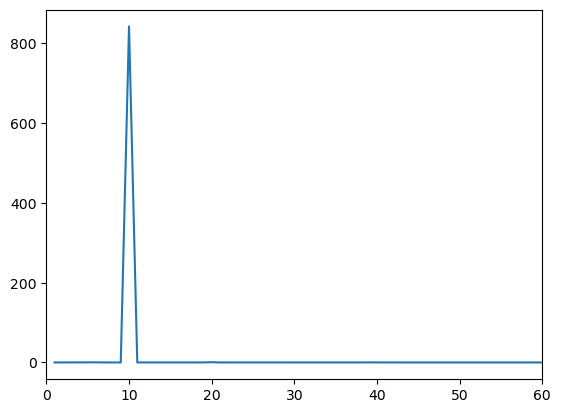

In [ ]:
import matplotlib.pyplot as plt
plt.plot(freqs, ((Gamma_est[:,0,0] + Gamma_est[:,1,1])/2)**2 
            + ((Gamma_est[:,2,2] + Gamma_est[:,3,3])/2)**2)
plt.xlim([0,60])

In [ ]:
from cohlib.alg.em_sgc import construct_Gamma_full_real
full_test = construct_Gamma_full_real(Gamma_est, K, num_J_vars, invert=True)

In [ ]:
Gamma_true_real = np.zeros((num_freqs, K*2, K*2))
inv_Gamma_true_real = np.zeros((num_freqs, K*2, K*2))
for j in range(int(num_freqs/2)):
    Gamma_true_real_j = conv_ccov_to_real(Gamma[j,:,:]) 
    Gamma_true_real[j,:,:] = Gamma_true_real_j
    inv_Gamma_true_real[j,:,:] = np.linalg.inv(Gamma_true_real_j)

In [ ]:
Gamma[499,:,:]

array([[ 8.95218871+0.j        , -0.02690103-0.01121946j],
       [-0.02690103+0.01121946j,  2.09177574+0.j        ]])

In [ ]:
num_freqs/2

500.0

In [ ]:
j = 5
np.round(inv_Gamma_true_real[j,:,:],5)

array([[ 0.52026, -0.00451, -0.     , -0.00152],
       [-0.00451,  0.69487,  0.00152,  0.     ],
       [-0.     ,  0.00152,  0.52026, -0.00451],
       [-0.00152,  0.     , -0.00451,  0.69487]])

In [ ]:
from cohlib.alg.em_sgc import fit_sgc_model
inits = {'Gamma': full_inv_Gamma_real}

Gamma_update = fit_sgc_model(spikes_short, W, inits, num_em_iters=1, max_approx_iters=10, track=False)

EM iter: 0
Laplace Approx trial 0
Laplace Approx trial 1
Laplace Approx trial 2
Laplace Approx trial 3
Laplace Approx trial 4
M-Step for EM iter 0


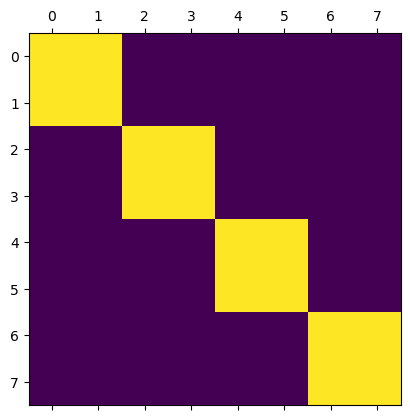

In [ ]:
test = construct_Gamma_full_real(gammaupdate, K, J)
import matplotlib.pyplot as plt
plt.matshow(~(test==0)[J+0:J+8,0:8])

In [ ]:
from cohlib.alg.em_sgc import construct_Gamma_full_real
# test = construct_Gamma_full_real(gammaupdate, K, J, invert=True)

In [ ]:
def conv_ccov_to_real(ccov):
    dim = ccov.shape[0]
    A = np.real(ccov)
    B = np.imag(ccov)
    rcov = np.zeros((2*dim, 2*dim))

    # real components
    rcov[:dim,:dim] = A
    rcov[dim:,dim:] = A

    # imag components
    rcov[:dim,dim:] = B
    rcov[dim:,:dim] = -B
    return 0.5*rcov

In [ ]:
A1 = np.ones((3,3))*11 + 0j
A2 = np.ones((3,3))*12 + 0j
A3 = np.ones((3,3))*13 + 0j
B1 = np.ones((3,3))*21 + 0j
B2 = np.ones((3,3))*22 + 0j
B3 = np.ones((3,3))*23 + 0j
C1 = np.ones((3,3))*31 + 0j
C2 = np.ones((3,3))*32 + 0j
C3 = np.ones((3,3))*33 + 0j
zeros = np.zeros((3,3))
r1 = np.hstack([A1, A2, A3])
r2 = np.hstack([B1, B2, B3])
r3 = np.hstack([C1, C2, C3])

G = np.vstack([r1, r2, r3])
GJ = G + Jma
GJ

array([[11.+1.j, 11.+0.j, 11.+0.j, 12.+1.j, 12.+0.j, 12.+0.j, 13.+1.j,
        13.+0.j, 13.+0.j],
       [11.+0.j, 11.+2.j, 11.+0.j, 12.+0.j, 12.+2.j, 12.+0.j, 13.+0.j,
        13.+2.j, 13.+0.j],
       [11.+0.j, 11.+0.j, 11.+3.j, 12.+0.j, 12.+0.j, 12.+3.j, 13.+0.j,
        13.+0.j, 13.+3.j],
       [21.+1.j, 21.+0.j, 21.+0.j, 22.+1.j, 22.+0.j, 22.+0.j, 23.+1.j,
        23.+0.j, 23.+0.j],
       [21.+0.j, 21.+2.j, 21.+0.j, 22.+0.j, 22.+2.j, 22.+0.j, 23.+0.j,
        23.+2.j, 23.+0.j],
       [21.+0.j, 21.+0.j, 21.+3.j, 22.+0.j, 22.+0.j, 22.+3.j, 23.+0.j,
        23.+0.j, 23.+3.j],
       [31.+1.j, 31.+0.j, 31.+0.j, 32.+1.j, 32.+0.j, 32.+0.j, 33.+1.j,
        33.+0.j, 33.+0.j],
       [31.+0.j, 31.+2.j, 31.+0.j, 32.+0.j, 32.+2.j, 32.+0.j, 33.+0.j,
        33.+2.j, 33.+0.j],
       [31.+0.j, 31.+0.j, 31.+3.j, 32.+0.j, 32.+0.j, 32.+3.j, 33.+0.j,
        33.+0.j, 33.+3.j]])

In [ ]:
G[j_filt].reshape(K,-1)

array([[11., 12., 13.],
       [21., 22., 23.],
       [31., 32., 33.]])

In [ ]:
from cohlib.utils import conv_complex_to_real

def conv_zs_to_vs(zs, dc=False):
    L = zs.shape[0]
    J = zs.shape[1]
    if dc:
        vs = np.zeros((L, int(J*2))+1)
        vs[:,0] = zs[:,zs[0].real]
        dcshift = 1
    else:
        vs = np.zeros((L, int(J*2)))
        dcshift = 0

    # temp = []
    for l in range(L):
        for j in range(int(J)):
            ind = j + dcshift
            z = zs[l,ind]
            v1,v2 = conv_complex_to_real(z)

            vi = j*2 + dcshift
            vs[l,vi] = v1
            vs[l,vi+1] = v2
            # temp.append(v1)
            # temp.append(v2)

    # return vs, temp
    return vs


